# Project Features

In [1]:
import spacy
from spacy.lang.en import English
from scipy import sparse

spacy_nlp = English()
def spacy_tokenizer(text):
    tokens = spacy_nlp.tokenizer(text)
    return [token.text for token in tokens]

def project_WordFeatures(tokens):
    feats = {}
    for word in tokens:
        feat = 'WORD_%s' % word
        if feat in feats:
            feats[feat] +=1
        else:
            feats[feat] = 1
    return feats

def project_AddFeatures(feats, new_feats):
    for feat in new_feats:
        if feat in feats:
            feats[feat] += new_feats[feat]
        else:
            feats[feat] = new_feats[feat]
    return feats

def docs2features(trainX, feature_functions, tokenizer):
    examples = []
    count = 0
    for doc in trainX:
        feats = {}
        tokens = tokenizer(doc)
        for func in feature_functions:
            project_AddFeatures(feats, func(tokens))
        examples.append(feats)
        count +=1
        if count % 200 == 0:
            print('Succesfully Processed %d examples' % len(examples))
    return examples

def create_vocab(examples):
    project_FeatureVocab = {}
    idx = 0
    for example in examples:
        for feat in example:
            if feat not in project_FeatureVocab:
                project_FeatureVocab[feat] = idx
                idx += 1
                
    return project_FeatureVocab

def features_to_ids(examples, project_FeatureVocab):
    new_examples = sparse.lil_matrix((len(examples), len(project_FeatureVocab)))
    for idx, example in enumerate(examples):
        for feat in example:
            if feat in project_FeatureVocab:
                new_examples[idx, project_FeatureVocab[feat]] = example[feat]
    return new_examples

def project_FeatureLen(tokens):
    feat = {'DOC_LEN' : len(tokens)}
    return feat

def project_FeatureUrls(tokens):
    count = 0
    for token in tokens:
        if 'URL' in token:
            count += 1
    return {'URLS':count}

def project_FeatureMentions(tokens):
    count = 0
    for token in tokens:
        if 'MENTION' in token:
            count += 1          
    return {'MENTIONS':count}

def project_FeatureHashtags(tokens):
    count = 0
    for token in tokens:
        if 'HASHTAG' in token:
            count += 1
    return {'HASHTAGS':count}

def project_FeatureRetweet(tokens):
    retweet = 0
    for token in tokens:
        if token.lower() == 'rt':
            retweet += 1           
    return {'RETWEET_COUNT' : retweet}

def project_FeatureStopwords(tokens):
    stopwords = spacy_nlp.Defaults.stop_words
    count = 0
    for token in tokens:
        if token.isalpha():
            if token.lower() in stopwords:
                count += 1
    return {'DEICTIC_COUNT':count} 


# Data Pre-processing

In [2]:
import re
from scipy import sparse
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

def read_examples(filename):
    X = []
    Y = []
    
    
    with open(filename, mode = 'r') as file:
        urls = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mentions = '@[\w\-]+'
        hashtags = '#[\w\-]+'
        
        
        for line in file:
            [label, text] = line.rstrip().split('\t', maxsplit = 1)
            text1 = re.sub(urls, 'URL', text)
            text1 = re.sub(mentions, 'MENTION', text1)
            text1 = re.sub(hashtags, 'HASHTAG', text1)
            
            X.append(text1)
            Y.append(label)
            
    return X, Y

def label_counts(Y):
    labels = {}
    for l in Y:
        if l in labels:
            labels[l] += 1
        else:
            labels[l] = 1

    return labels
    
def read_examples(filename):
    X = []
    Y = []
    with open(filename, mode = 'r') as file:
        for line in file:
            [label, text] = line.rstrip().split('\t', maxsplit = 1)
            X.append(text)
            Y.append(label)
    return X, Y



# Main class

In [3]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

datapath = "../data/twitter"
train_file = os.path.join(datapath, 'train.txt')
trainX, trainY = read_examples(train_file)
print("Training examples:", label_counts(trainY))


dev_file = os.path.join(datapath, 'dev.txt')
devX, devY = read_examples(dev_file)
print("Development examples:", label_counts(devY))


test_file = os.path.join(datapath, 'test.txt')
testX, testY = read_examples(test_file)
print("Test examples:", label_counts(testY))


def train_and_test(trainX, trainY, devX, devY, feature_functions, tokenizer):    
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)
    project_FeatureVocab = create_vocab(trainX_feat)
    print('Vocab size is: %d' % len(project_FeatureVocab))
    print('\n')
    trainX_ids = features_to_ids(trainX_feat, project_FeatureVocab)   
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000)
    lr_model.fit(trainX_ids, trainY)  
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, project_FeatureVocab)
    print('Accuracy is: %.3f' % lr_model.score(devX_ids, devY))

print('\nWord\n')
features = [project_WordFeatures]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Urls\n')
features = [project_WordFeatures, project_FeatureUrls]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Urls, Mentions\n')
features = [project_WordFeatures, project_FeatureUrls, project_FeatureMentions]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Urls, Mentions, Hashtags\n')
features = [project_WordFeatures, project_FeatureUrls, project_FeatureMentions, project_FeatureHashtags]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Urls, Mentions, Hashtags, Length\n')
features = [project_WordFeatures, project_FeatureUrls, project_FeatureMentions, project_FeatureHashtags, project_FeatureLen]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Urls, Mentions, Hashtags, Length, StopWords\n')
features = [project_WordFeatures, project_FeatureUrls, project_FeatureMentions, project_FeatureHashtags, project_FeatureLen, project_FeatureStopwords]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Urls, Mentions, Hashtags, Length, StopWords, Retweet\n')
features = [project_WordFeatures, project_FeatureUrls, project_FeatureMentions, project_FeatureHashtags, project_FeatureLen, project_FeatureStopwords, project_FeatureRetweet]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

print('\nWord, Mentions, Hashtags, Retweet\n')
features = [project_WordFeatures, project_FeatureMentions, project_FeatureHashtags, project_FeatureRetweet]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Training examples: {'hate': 1367, 'normal': 2732}
Development examples: {'hate': 671, 'normal': 610}
Test examples: {'hate': 829, 'normal': 319}

Word

Succesfully Processed 200 examples
Succesfully Processed 400 examples
Succesfully Processed 600 examples
Succesfully Processed 800 examples
Succesfully Processed 1000 examples
Succesfully Processed 1200 examples
Succesfully Processed 1400 examples
Succesfully Processed 1600 examples
Succesfully Processed 1800 examples
Succesfully Processed 2000 examples
Succesfully Processed 2200 examples
Succesfully Processed 2400 examples
Succesfully Processed 2600 examples
Succesfully Processed 2800 examples
Succesfully Processed 3000 examples
Succesfully Processed 3200 examples
Succesfully Processed 3400 examples
Succesfully Processed 3600 examples
Succesfully Processed 3800 examples
Succesfully Processed 4000 examples
Vocab size is: 13542


Succesfully Processed 200 examples
Succesfully Processed 400 examples
Succesfully Processed 600 examples
Succ


Word, Urls, Mentions, Hashtags, Length, StopWords, Retweet

Succesfully Processed 200 examples
Succesfully Processed 400 examples
Succesfully Processed 600 examples
Succesfully Processed 800 examples
Succesfully Processed 1000 examples
Succesfully Processed 1200 examples
Succesfully Processed 1400 examples
Succesfully Processed 1600 examples
Succesfully Processed 1800 examples
Succesfully Processed 2000 examples
Succesfully Processed 2200 examples
Succesfully Processed 2400 examples
Succesfully Processed 2600 examples
Succesfully Processed 2800 examples
Succesfully Processed 3000 examples
Succesfully Processed 3200 examples
Succesfully Processed 3400 examples
Succesfully Processed 3600 examples
Succesfully Processed 3800 examples
Succesfully Processed 4000 examples
Succesfully Processed 200 examples
Succesfully Processed 400 examples
Succesfully Processed 600 examples
Succesfully Processed 800 examples
Succesfully Processed 1000 examples
Succesfully Processed 1200 examples


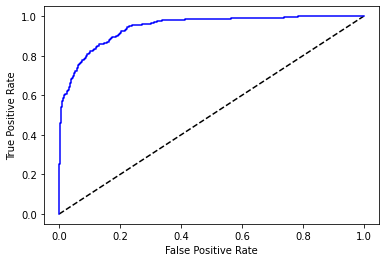

In [4]:
datapath = '../data/twitter'

train_file = os.path.join(datapath, 'train.txt')
trainX, trainY = read_examples(train_file)

dev_file = os.path.join(datapath, 'dev.txt')
devX, devY = read_examples(dev_file)

def train_and_test1(trainX, trainY, devX, devY, feature_functions, tokenizer):
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)
    project_FeatureVocab = create_vocab(trainX_feat)
    trainX_ids = features_to_ids(trainX_feat, project_FeatureVocab)
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, project_FeatureVocab)
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000)
    lr_model.fit(trainX_ids, trainY) 
    lr_probs = lr_model.predict_proba(devX_ids)[:, 1]
    devY_num = []
    for x in devY:
        if x == 'hate':
            devY_num.append(0)
        else:
            devY_num.append(1)
    fpr1, tpr1, thresholds1 = roc_curve(devY_num, lr_probs)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr1, tpr1, label='Logistic Regression', color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

print('\nWord, Urls, Mentions, Hashtags, Length, StopWords, Retweet\n')
features = [project_WordFeatures, project_FeatureUrls, project_FeatureMentions, project_FeatureHashtags, project_FeatureLen, project_FeatureStopwords, project_FeatureRetweet]
train_and_test1(trainX, trainY, devX, devY, features, spacy_tokenizer)